In [ ]:
# Original Authors: The MNE-Python contributors.
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

# Análisis de eventos a partir de datos crudos.
&emsp;&emsp;&emsp;&emsp;**Basado en el tutorial introductorio de MNE: [Parsing events from raw data](https://mne.tools/stable/auto_tutorials/intro/20_events_from_raw.html)**

## ¿Qué es un evento?
Los eventos corresponden a puntos específicos de tiempo en datos crudos, como *Triggers*, condiciones experimentales, etc. En MNE-Python, se codifican en **canales STIM**.

En este tutorial se verán ejemplos de lectura de eventos experimentales de canales STIM; se discutirán más sobre los términos *eventos* y *anotaciones*, así como información más detallada sobre los canales STIM, y se dará un ejemplo sobre la lectura de eventos que están en un archivo marcador o incluidos en un archivo como un *array*. 

Empezaremos importando las librerías necesarias y cargando la data de ejemplo usada en el tutorial introductorio.

In [1]:
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder  /"MEG"/"sample"/"sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60).load_data()  # Limitamos los datos a 60s antes de cargarlos en RAM para acelerar el procesamiento

Opening raw data file C:\Users\J-Est\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


### Estructura de los datos de Eventos y Anotaciones.
En general, la estructura tanto de `Eventos` como de `Anotaciones` tiene el mismo propósito: Ofrecen un mapeado entre tiempos durante una grabación de EEG / MEG y una descripción de lo que sucedió en dichos momentos, en otras palabras,  **asocian el "cuando" y el "que"**. Sus principales diferencias son:
    1. **Unidades:** Los `Eventos` presentan el *cuando* en términos de muestras (samples), mientras que las `Anotaciones` lo hacen en segundos.
    2. **Límites en la descripción:** Los `Eventos` representan el *que* como enteros o *IDs de eventos*, mientras que las `Anotaciones` lo hacen como strings.
    3. **Como se codifica la duración:** Los `Eventos` en un array de eventos no poseen duración (aunque es posible representar duración pareando eventos de inicio y final), mientras que cada elemento de un objeto tipo `Anotación` necesariamente incluye una duración (aunque puede ser igual a cero, si se desea una anotación instantánea).
    4. **Representación interna:** Los `Eventos` se almacenan como arrays de NumPy, mientras que las `Anotaciones` son clases similares a listas definidas en MNE-Python.

### ¿Qué es un canal STIM?
Abreviación de "*Canal de estímulos*" (stimulus channel), son canales que no reciben señales de ningún sensor. En su lugar, graban voltajes (usualmente, pulsos rectangulares de corriente directa de magnitudes fijas enviadas desde el ordenador que controla el experimento) que se relacionan temporalmente con eventos experimentales, como el inicio de un estímulo o una pulsación de un botón por parte del sujeto (estas pulsaciones se suelen llamar *pulsos TTL*, *pulsos de evento*, *señales trigger* o solo *triggers*). En otros casos, estos pulsos podrían no estar estrictamente relacionados temporalmente con un evento, sino ocurrir entre pruebas para indicar el tipo de estímulo (o condición experimental) que está por ocurrir.

Todos los pulsos DC pueden estar en un solo canal STIM (en cuyo caso diferentes eventos o tipos de pruebas se codifican a diferentes magnitudes de voltaje), o pueden almacenarse en varios canales, en cuyo caso puede usarse cada canal para codificar diferentes eventos o condiciones. Incluso en sistemas con multiples canales STIM, hay un canal que graba la suma ponderada de los otros canales STIM, de tal manera que los niveles de voltaje en dicho canal pueden ser decodificados de manera no ambigua en tipos de evento particulares. 

En antiguos sistemas Neuromag (como el del ejemplo) este "canal sumado" era típicamente el `STI 014`; en sistemas mas nuevos, es mas comumente el `STI101`. Se pueden observar los canales STIM de los datos crudos de la siguiente manera:

Using matplotlib as 2D backend.


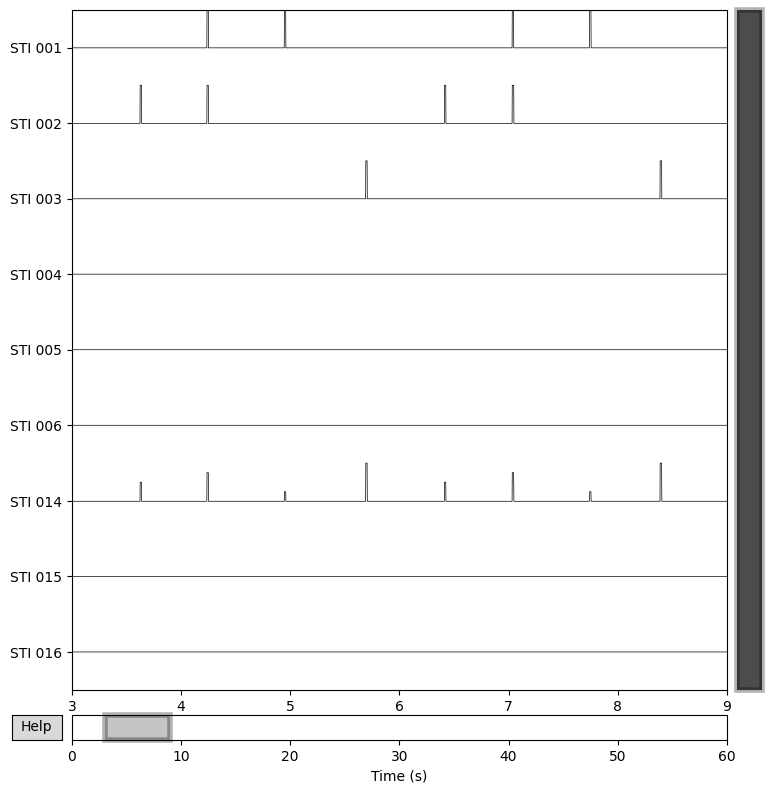

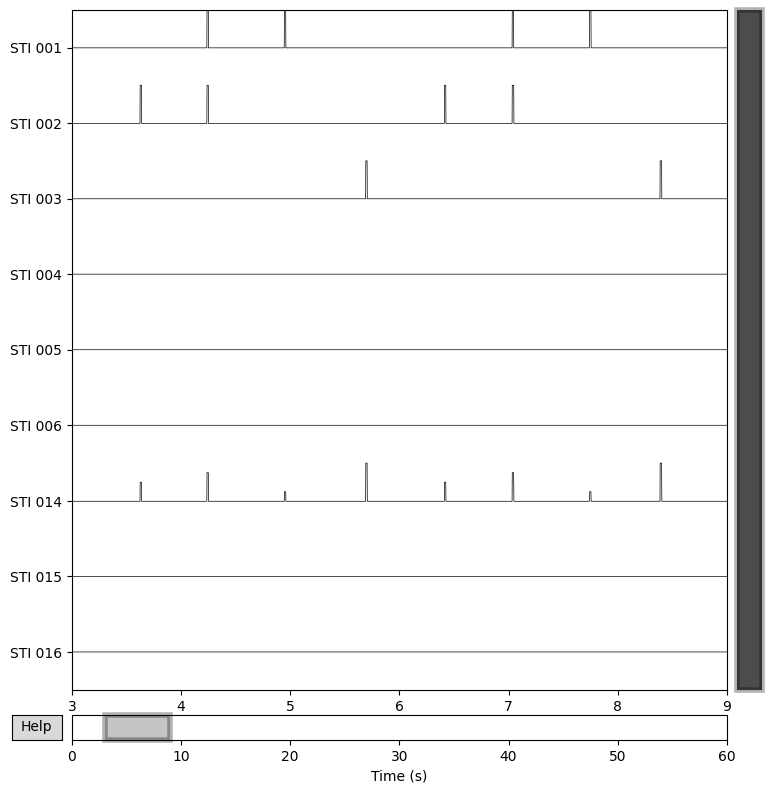

In [2]:
raw.copy().pick(picks="stim").plot(start=3, duration=6)

### Convirtiendo la señal de un canal STIM en un array de eventos.
Se puede lograr usando `find_events`. El número de muestra en el inicio (o final) de cada pulso es grabado como el tiempo de evento, la magnitud de los pulsos es convertido a enteros, y este par de número de muestra y códigos de enteros son guardados en un array de NumPy (usualmente llamado *array de eventos* o solo *eventos*). En su formas más simple, la función requiere solo de un objeto `Raw`, y el nombre del canal o canales de los que lee los eventos:

In [3]:
events = mne.find_events(raw, stim_channel="STI 014")
print(events[:5])  # Imprimimos los primeros 5 eventos

86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


Se compone de 3 columnas: El número de muestra, el entero de código de evento, y entre ellos que indica el código de evento presenta en la muestra inmediatamente anterior. En la práctica, este valor es casi siempre 0, pero puede ser usado para detectar el final de un evento cuya duración va más allá de una muestra.

Se puede configurar la variable `MNE_STIM_CHANNEL`, si se trabaja seguido con datos de un mismo sistema con el mismo nombre de canales STIM.

`find_events` posee varias opciones para el alineamiento de eventos respecto a pulsos en los canales STIM, establecer una duración de pulso mínima, y el manejo de pulsos consecutivos.

### Leyendo eventos como anotaciones.
...